In [1]:
import pickle
import os
from glob import glob
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from model import analyse, visualise
import numpy as np

plt.style.use(style="ggplot")

# font size in the paper is 9
plt.rcParams.update({"font.size": 9})

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 7.00697
SINGLE_COLUMN_FIG_WIDTH = 3.3374

# Experiment 2

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment2/experiment2_output"
file_pattern = "experiment2_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):

    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.append(run_results)

In [3]:
list(results[0].keys())

['run_id',
 'duration',
 'seed',
 'n_agents',
 'params',
 'run_length',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

In [4]:
avg_duration = sum([res["duration"] for res in results], start=datetime.timedelta(0)) / len(results)
print(avg_duration)

3 days, 17:59:22.203396


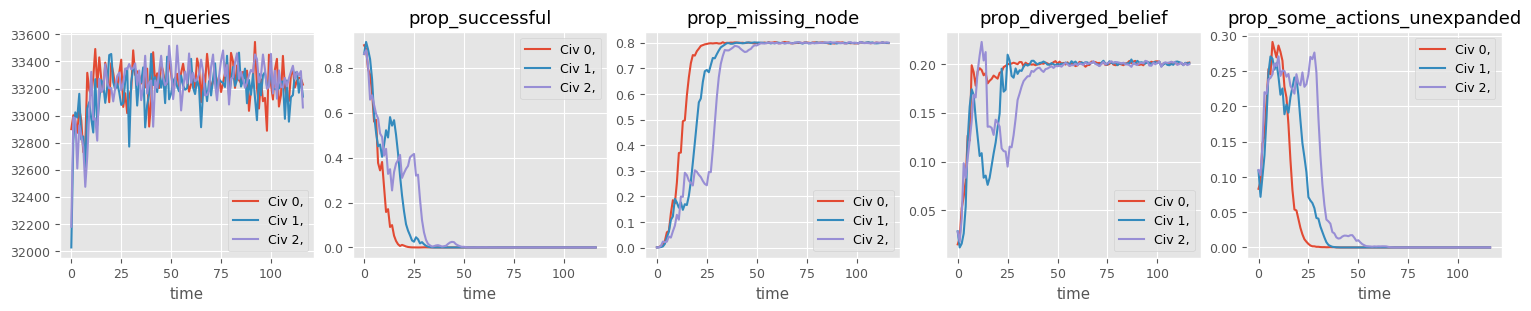

In [5]:
res = results[0]

# let's turn the results into a DataFrame
rows = []

for t, time_step_data in enumerate(res["lower_tree_query_data"]):
    for tree, values in time_step_data.items():
        # if there are no queries, skip
        if values[0] == 0:
            continue

        rows.append((t, tree, *values))

query_data = pd.DataFrame(
    rows,                       
    columns=(
        'time', 
        'tree', 
        'n_queries', 
        'prop_successful', 
        'prop_missing_node', 
        'prop_diverged_belief', 
        'prop_some_actions_unexpanded'
    )
)

# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15,3))

for i, column in enumerate(query_data.columns[2:]):

    for tree, tree_data in query_data.groupby('tree'):

        axs[i].plot('time', column, data=tree_data, label=tree)

    axs[i].set_title(column)
    axs[i].legend()
    axs[i].set_xlabel('time')
    

Let's visualise the query success rates as averages over all runs over time.

In [14]:
# let's turn the results into a DataFrame
rows = []

# the simulations are level 1
tree_levels = {"Civ 0,": 1, "Civ 1,": 1, "Civ 2,": 1, "Civ 3,": 1, "Civ 4,": 1}

for run_result in results:

    n_agents = run_result["n_agents"]

    for t, time_step_data in enumerate(run_result["lower_tree_query_data"]):
        for tree, values in time_step_data.items():
            # if there are no queries, skip
            if values[0] == 0:
                continue

            level = tree_levels[tree]

            rows.append((t, n_agents, level, *values))

query_data = pd.DataFrame(
    rows,                       
    columns=(
        'time', 
        'n_agents',
        'level',
        'n_queries', 
        'prop_successful', 
        'prop_missing_node', 
        'prop_diverged_belief', 
        'prop_some_actions_unexpanded'
    )
)

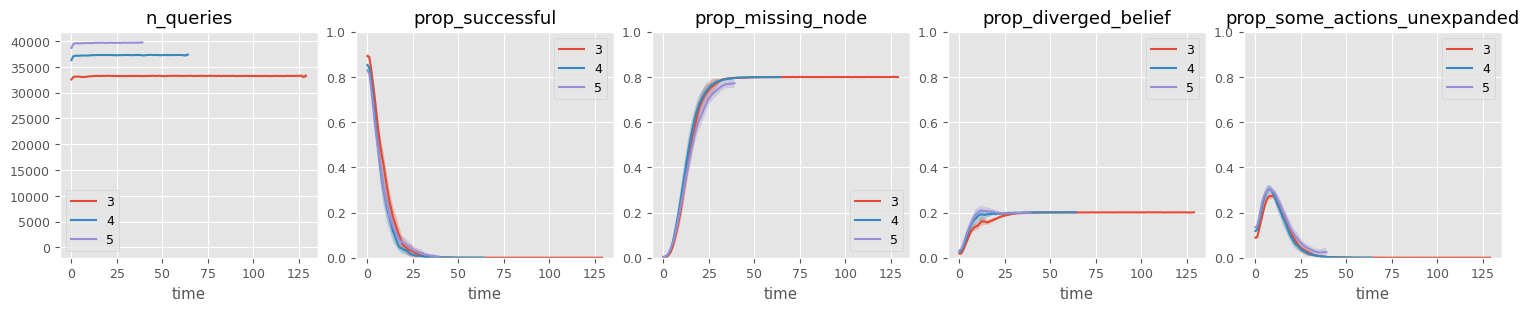

In [19]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15,3))

for i, metric in enumerate(query_data.columns[-5:]):

    for n_agents, n_agents_data in query_data.groupby('n_agents'):

        avg_metric = n_agents_data.groupby("time")[metric].mean()
        avg_metric_error_margin = n_agents_data.groupby("time")[metric].aggregate(lambda x: analyse.t_confidence_interval(x)[1])


        axs[i].plot(avg_metric.index, avg_metric, label=n_agents)
        axs[i].fill_between(avg_metric.index, 
                        avg_metric + avg_metric_error_margin, 
                        avg_metric - avg_metric_error_margin, alpha=0.3)
        #axs[i].plot('time', column, data=tree_data, label=tree)

    axs[i].set_title(metric)
    axs[i].legend()
    axs[i].set_xlabel('time')

    if metric != "n_queries":
        axs[i].set_ylim((0,1))
    else:
        # add point 0 to data limits so scaling is correct
        axs[i].update_datalim([(0, 0)])
    
plt.show()

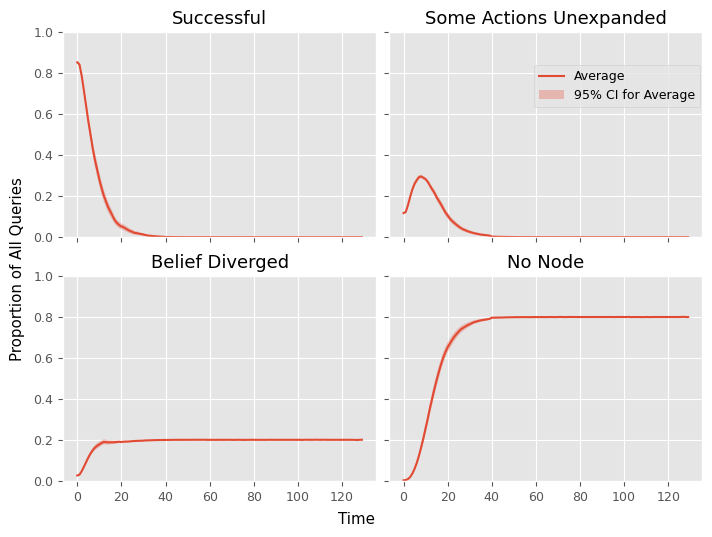

In [10]:
# plot
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, 
                        figsize=(TWO_COLUMN_FIG_WIDTH, 0.75*TWO_COLUMN_FIG_WIDTH),
                        sharex=True, sharey=True)

ax_indices = {"prop_successful": (0, 0), 
              "prop_missing_node": (1, 1),
              "prop_diverged_belief": (1, 0),
              "prop_some_actions_unexpanded": (0, 1)}

pretty_titles = {"prop_successful": "Successful",
                 "prop_missing_node": "No Node",
                 "prop_diverged_belief": "Belief Diverged",
                 "prop_some_actions_unexpanded": "Some Actions Unexpanded"}

for metric in query_data.columns[-4:]:

    ax = axs[*ax_indices[metric]]

    for level, level_data in query_data.groupby('level'):

        avg_metric = level_data.groupby("time")[metric].mean()
        avg_metric_error_margin = level_data.groupby("time")[metric].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

        ax.plot(avg_metric.index, avg_metric, label="Average")
        ax.fill_between(avg_metric.index, 
                        avg_metric + avg_metric_error_margin, 
                        avg_metric - avg_metric_error_margin, alpha=0.3,
                        label="95% CI for Average")

    ax.set_title(pretty_titles[metric])
    #ax.legend()

    if metric != "n_queries":
        ax.set_ylim((0,1))
    else:
        # add point 0 to data limits so scaling is correct
        ax.update_datalim([(0, 0)])
    
fig.supxlabel("Time")
fig.supylabel("Proportion of All Queries")

handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(unique_labels.values(), unique_labels.keys(), loc=(0.75, 0.8))

plt.savefig("paper/lower_tree_queries.pdf")
plt.show()

Let's calculate the average proportion of all actions that are attacks at each reward level:

In [11]:
rows = []

for run_result in results:

    if run_result["run_length"] < 50:
        continue

    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["reasoning_level"]
    run_actions = run_result["actions"]

    prop_no_action = ((run_actions["action"] == 0) | ((run_actions["action"] == "a") & (run_actions["attack_successful"].isnull()))).mean()
    prop_attack = ((run_actions["action"] == "a") & (~run_actions["attack_successful"].isnull())).mean()
    #prop_no_action = (run_actions["action"] == 0).mean()
    #prop_attack = (run_actions["action"] == "a").mean()
    prop_hide = ((run_actions["action"] == 1)).mean()
    rows.append((attack_reward, reasoning_level, prop_no_action, prop_attack, prop_hide))

prop_action_data = pd.DataFrame(rows, columns=('attack_reward', 'reasoning_level', 'prop_no_action', 'prop_attack', 'prop_hide'))

# add bins for attack reward
bins = np.linspace(-0.2, 0.1, 61)
prop_action_data["attack_reward_bin"] = pd.cut(x=prop_action_data["attack_reward"], bins=bins, include_lowest=True)

KeyError: 'attack_reward'

In [107]:
prop_action_data.groupby("attack_reward_bin").size()

attack_reward_bin
(-0.201, -0.195]      13
(-0.195, -0.19]       14
(-0.19, -0.185]       10
(-0.185, -0.18]       15
(-0.18, -0.175]        9
(-0.175, -0.17]       10
(-0.17, -0.165]       12
(-0.165, -0.16]       11
(-0.16, -0.155]       17
(-0.155, -0.15]       14
(-0.15, -0.145]       12
(-0.145, -0.14]       18
(-0.14, -0.135]       12
(-0.135, -0.13]       10
(-0.13, -0.125]       12
(-0.125, -0.12]       14
(-0.12, -0.115]       11
(-0.115, -0.11]       16
(-0.11, -0.105]        7
(-0.105, -0.1]        18
(-0.1, -0.095]         9
(-0.095, -0.09]        8
(-0.09, -0.085]       15
(-0.085, -0.08]       14
(-0.08, -0.075]       11
(-0.075, -0.07]       20
(-0.07, -0.065]        5
(-0.065, -0.06]       16
(-0.06, -0.055]       12
(-0.055, -0.05]       11
(-0.05, -0.045]       17
(-0.045, -0.04]        9
(-0.04, -0.035]       14
(-0.035, -0.03]       11
(-0.03, -0.025]       13
(-0.025, -0.02]       14
(-0.02, -0.015]        9
(-0.015, -0.01]        9
(-0.01, -0.005]        8
(-0.005

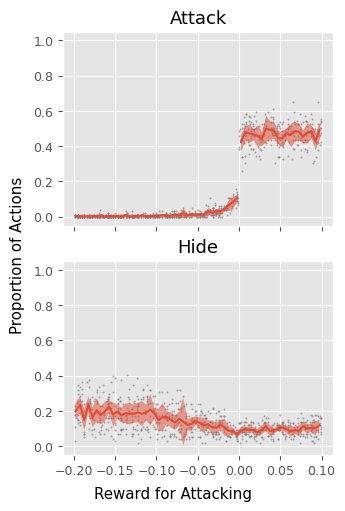

In [149]:
metrics = ("prop_attack", "prop_hide")
fancy_titles = {"prop_no_action": "No action", "prop_attack": "Attack", "prop_hide": "Hide"}

fig, axs = plt.subplots(ncols=1, nrows=len(metrics), constrained_layout=True, figsize=(SINGLE_COLUMN_FIG_WIDTH, 2.5*len(metrics)), sharey=True, sharex=True)

for i, metric in enumerate(metrics):

    axs[i].scatter(x=prop_action_data["attack_reward"], y=prop_action_data[metric], s=1, c="grey", alpha=0.5)

    prop_action_data_groups = prop_action_data.groupby("attack_reward_bin")
    avg_metric = prop_action_data_groups.mean()[metric]
    avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1])[metric]
    midpoints = pd.IntervalIndex(avg_metric.index).mid

    # show discontinuity at 0
    if metric == "prop_attack":
        subset = midpoints < 0
        lines = axs[i].plot(midpoints[subset], avg_metric[subset])
        color = lines[0].get_color()
        axs[i].fill_between(midpoints[subset], avg_metric[subset]-avg_metric_error_margin[subset], avg_metric[subset] + avg_metric_error_margin[subset], color=color, alpha=0.5)

        subset = midpoints > 0
        axs[i].plot(midpoints[subset], avg_metric[subset], color=color)
        axs[i].fill_between(midpoints[subset], avg_metric[subset]-avg_metric_error_margin[subset], avg_metric[subset] + avg_metric_error_margin[subset], color=color, alpha=0.5)
    else:
        axs[i].plot(midpoints, avg_metric)
        axs[i].fill_between(midpoints, avg_metric-avg_metric_error_margin, avg_metric + avg_metric_error_margin, alpha=0.5)

    #axs[i].errorbar(x=midpoints, y=avg_metric, yerr=avg_metric_error_margin, capsize=3, fmt="none")

    #axs[i].set_xlabel("Reward for attacking")
    #axs[i].set_ylabel("Proportion of actions")
    axs[i].set_title(fancy_titles[metric])
    axs[i].set_ylim((-0.05, 1.05))

fig.supxlabel("Reward for Attacking")
fig.supylabel("Proportion of Actions")

#plt.savefig("experiment3_prop_actions.pdf")
plt.show()

Only reasoning level 0:

/var/folders/b1/0yhqwzb14fzdb3l1pcmd5tb00000gn/T/ipykernel_82303/190849686.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_metric = prop_action_data_groups.mean()[metric]
/var/folders/b1/0yhqwzb14fzdb3l1pcmd5tb00000gn/T/ipykernel_82303/190849686.py:7: FutureWarning: ['attack_reward_bin'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]
/var/folders/b1/0yhqwzb14fzdb3l1pcmd5tb00000gn/T/ipykernel_82303/190849686.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify 

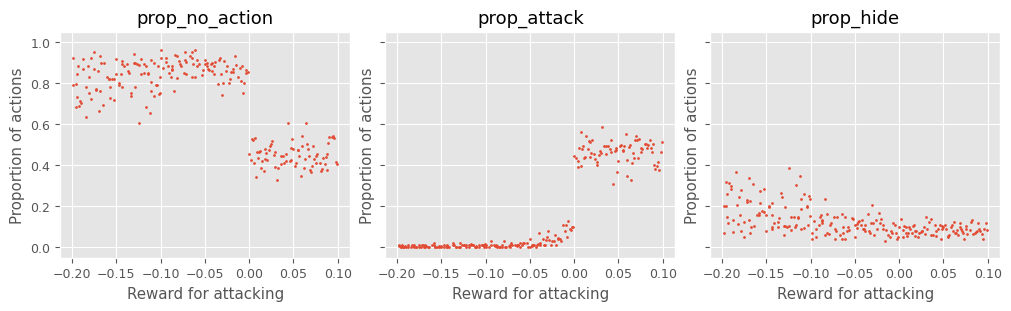

In [151]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3), sharey=True)

for i, metric in enumerate(("prop_no_action", "prop_attack", "prop_hide")):
    prop_action_data_groups = prop_action_data[prop_action_data["reasoning_level"] == 0].groupby("attack_reward")

    avg_metric = prop_action_data_groups.mean()[metric]
    avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]

    axs[i].scatter(x=avg_metric.index, y=avg_metric, s=2)
    #axs[i].errorbar(x=avg_metric.index, y=avg_metric, yerr=avg_metric_error_margin, fmt="none", capsize=3)

    axs[i].set_xlabel("Reward for attacking") 
    axs[i].set_ylabel("Proportion of actions")
    axs[i].set_title(metric)
    #axs[i].grid()
    axs[i].set_ylim((-0.05, 1.05))

plt.show()

Only reasoning level 1:

/var/folders/b1/0yhqwzb14fzdb3l1pcmd5tb00000gn/T/ipykernel_82303/3548369450.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_metric = prop_action_data_groups.mean()[metric]
/var/folders/b1/0yhqwzb14fzdb3l1pcmd5tb00000gn/T/ipykernel_82303/3548369450.py:7: FutureWarning: ['attack_reward_bin'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]
/var/folders/b1/0yhqwzb14fzdb3l1pcmd5tb00000gn/T/ipykernel_82303/3548369450.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either speci

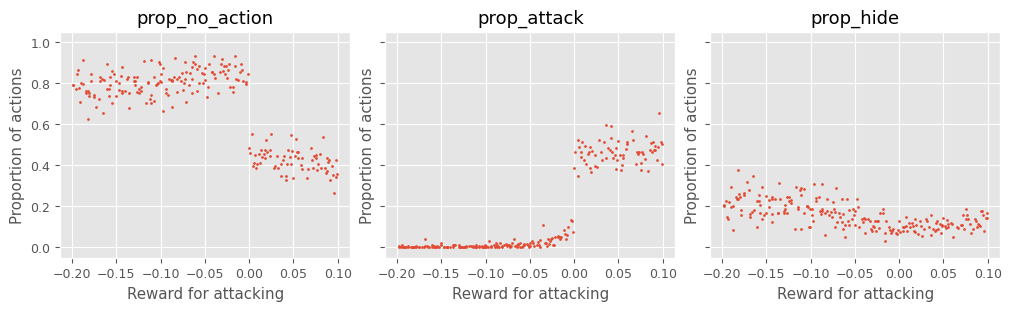

In [152]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3), sharey=True)

for i, metric in enumerate(("prop_no_action", "prop_attack", "prop_hide")):
    prop_action_data_groups = prop_action_data[prop_action_data["reasoning_level"] == 1].groupby("attack_reward")

    avg_metric = prop_action_data_groups.mean()[metric]
    avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]

    axs[i].scatter(x=avg_metric.index, y=avg_metric, s=2)
    #axs[i].errorbar(x=avg_metric.index, y=avg_metric, yerr=avg_metric_error_margin, fmt="none", capsize=3)

    axs[i].set_xlabel("Reward for attacking")
    axs[i].set_ylabel("Proportion of actions")
    axs[i].set_title(metric)
    #axs[i].grid()
    axs[i].set_ylim((-0.05, 1.05))

plt.show()

Let's then plot the average reward received by agents:

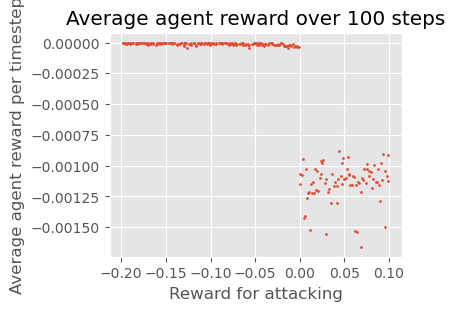

In [46]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    run_rewards = run_result["rewards"]
    avg_run_reward = run_rewards['reward'].mean() / (2 * 101)
    rows.append((attack_reward, avg_run_reward))

avg_reward_data = pd.DataFrame(rows, columns=('attack_reward', 'avg_run_reward'))

fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 3))

avg_reward_data_groups = avg_reward_data.groupby("attack_reward")
avg_avg_reward = avg_reward_data_groups.mean()["avg_run_reward"]
avg_avg_reward_error_margin = avg_reward_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]

ax.scatter(x=avg_avg_reward.index, y=avg_avg_reward, s=2)
#ax.errorbar(x=avg_avg_reward.index, y=avg_avg_reward, yerr=avg_avg_reward_error_margin, fmt="none", capsize=3)

ax.set_xlabel("Reward for attacking")
ax.set_ylabel("Average agent reward per timestep")
ax.set_title("Average agent reward over 100 steps")

plt.show()

This is a measure of the rationality of the system as a whole. The “rational” scenario for the system is when no one attacks or hides at all.

Next, let's investigate the length of attack streaks. We will only do this when the attack reward is either 0 or 0.1.

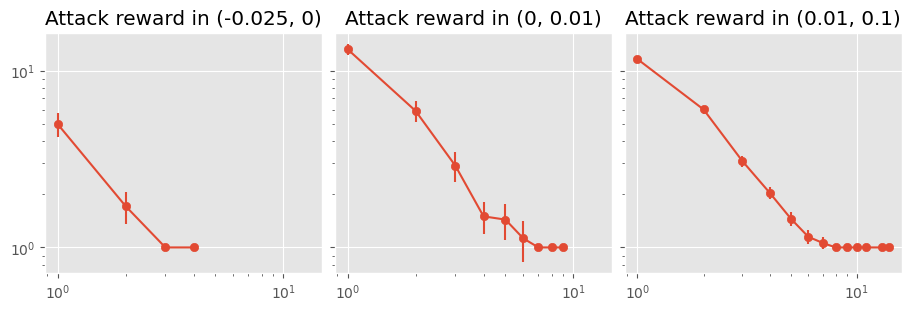

In [48]:
bins = ((-0.025, 0), (0, 0.01), (0.01, 0.1))

fig, axs = plt.subplots(nrows=1, ncols=len(bins), figsize=(3*len(bins), 3), constrained_layout=True, sharey=True)

rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]

    attack_reward_bin = None
    for i, (bin_l, bin_u) in enumerate(bins):
        if attack_reward >= bin_l and attack_reward < bin_u:
            attack_reward_bin = i
            break

    # if the attack reward is not in an interesting bin, ignore the run
    if attack_reward_bin is None:
        continue
    
    run_length = run_result["run_length"]
    # exclude runs that were less than 80 time steps (an arbitrary number)
    if run_length < 80:
        continue

    run_action_data = run_result["actions"]

    run_streaks = analyse.count_attack_streaks(run_action_data)

    for streak_length, count in run_streaks.items():
        rows.append((attack_reward_bin, streak_length, count))
    
attack_streak_data = pd.DataFrame(rows, columns=("attack_reward_bin", "streak_length", "streak_count"))


for i, (attack_reward_bin_i, attack_reward_attack_streak_data) in enumerate(attack_streak_data.groupby("attack_reward_bin")):

    attack_streak_data_grouped = attack_reward_attack_streak_data.groupby("streak_length")
    avg_streak_length_count = attack_streak_data_grouped["streak_count"].mean()
    avg_streak_length_count_error_margin = attack_streak_data_grouped["streak_count"].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    axs[i].scatter(avg_streak_length_count.index, avg_streak_length_count)
    axs[i].errorbar(x=avg_streak_length_count.index, y=avg_streak_length_count, yerr=avg_streak_length_count_error_margin)

    axs[i].update_datalim([(13, 1)])
    axs[i].set_yscale("log")
    axs[i].set_xscale("log")
    axs[i].set_title(f"Attack reward in {bins[attack_reward_bin_i]}")

plt.show()

Let us then start to quantify error in predicting the other agents' actions. First, we will plot the prediction error (norm of the difference vector of action utility estimates) over time for different attack rewards.

In [49]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["reasoning_level"]

    if reasoning_level == 0:
        continue

    action_utility_estimates = run_result["action_qualities"]

    for t, t_data in action_utility_estimates.groupby("time"):

        for estimator, actor in ((0,1), (1,0)):

            actor_estimate = t_data[(t_data["estimator"] == actor) & (t_data["actor"] == actor)]["qualities"].iloc[0]
            estimator_estimate = t_data[(t_data["estimator"] == estimator) & (t_data["actor"] == actor)]["qualities"].iloc[0]
            difference = np.linalg.norm(np.array(actor_estimate) - np.array(estimator_estimate))
            rows.append((attack_reward, t, difference))

action_utility_estimate_data = pd.DataFrame(rows, columns=("attack_reward", "time", "distance"))

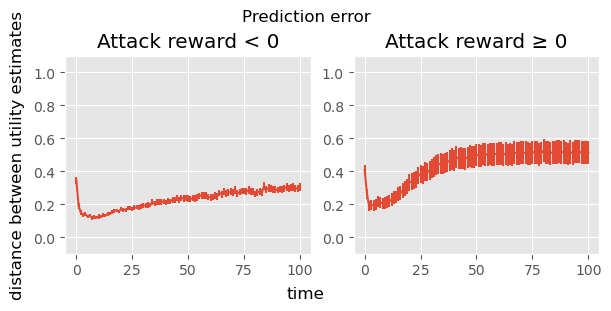

In [50]:
fig, axs = plt.subplots(constrained_layout=True, nrows=1, ncols=2, figsize=(6, 3))

negative_attack_reward = action_utility_estimate_data[action_utility_estimate_data["attack_reward"] < 0]
positive_attack_reward = action_utility_estimate_data[action_utility_estimate_data["attack_reward"] >= 0]

for i, (attack_reward_data) in enumerate((negative_attack_reward, positive_attack_reward)):

    avg_action_utility_estimate = attack_reward_data.groupby("time")["distance"].mean()
    avg_action_utility_estimate_error_margin = attack_reward_data.groupby("time")["distance"].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    if avg_action_utility_estimate.max() > 0.7:
        print(avg_action_utility_estimate)

    #lines = ax.plot(avg_action_utility_estimate.index, avg_action_utility_estimate, label=attack_reward)
    axs[i].errorbar(x=avg_action_utility_estimate.index, y=avg_action_utility_estimate, yerr=avg_action_utility_estimate_error_margin, label=attack_reward)
    axs[i].set_title(f"Attack reward {'< 0' if i == 0 else '≥ 0'}")
    axs[i].set_ylim((-0.1, 1.1))

fig.supxlabel("time")
fig.supylabel("distance between utility estimates")
fig.suptitle("Prediction error")
plt.show()